# Inport Data Analytics Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import ceil

# Import Machine Learning Libraries

In [2]:
from sklearn.pipeline import Pipeline

# To perform operations on columns:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ML algorithms:
from xgboost import XGBClassifier

# To evaluate performance model:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
# データ読み込み
X_y = pd.read_csv('titanic/train.csv', index_col='PassengerId')
X_test = pd.read_csv('titanic/test.csv', index_col='PassengerId')

# ターゲットが存在しない行を削除する
X_y = X_y.dropna(subset=['Survived'], axis=0)

# ターゲットyを予測変数Xから分離する
X = X_y.copy()
y = X.pop('Survived')

# 2)X,y Summary

In [4]:
X.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
y.head(5)

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [6]:
# 関数を作成しておく
def show_info(X, X_test):
    DataTypes = pd.DataFrame(X.dtypes.value_counts(),columns=['X'])
    DataTypes['X_test'] = X.dtypes.value_counts().values
    print("Number of Columns with different Data Types:\n")
    print(DataTypes,'\n')
    
    info = pd.DataFrame(X.dtypes, columns=['Dtype'])
    info['Unique_X'] = X.nunique().values
    info['Unique_X_test'] = X_test.nunique().values
    info['Null_X'] = X.isnull().sum().values
    info['Null_X_test'] = X_test.isnull().sum().values
    return info

In [7]:
DataTypes = pd.DataFrame(X.dtypes.value_counts(),columns=['X'])
DataTypes['X_test'] = X.dtypes.value_counts().values
print("Number of Columns with different Data Types:\n")
print(DataTypes,'\n')

Number of Columns with different Data Types:

         X  X_test
object   5       5
int64    3       3
float64  2       2 



In [8]:
show_info(X, X_test)

Number of Columns with different Data Types:

         X  X_test
object   5       5
int64    3       3
float64  2       2 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Pclass,int64,3,3,0,0
Name,object,891,418,0,0
Sex,object,2,2,0,0
Age,float64,88,79,177,86
SibSp,int64,7,7,0,0
Parch,int64,7,8,0,0
Ticket,object,681,363,0,0
Fare,float64,248,169,0,1
Cabin,object,147,76,687,327
Embarked,object,3,3,2,0


In [9]:
y.head(5)

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

# 3)Data Cleaning

In [10]:
def show_null_values(X, X_test):
    
    # Xのそれぞれのカラムの欠損値の数を抽出
    null_values = pd.DataFrame(X.isnull().sum(), columns=['Train Data'])
    # X_testのそれぞれのカラムの欠損値の数を抽出
    null_values['Test Data'] = X_test.isnull().sum().values
    
    # Train Data　or Test Dataのどちらかが０ではないデータを抽出する。
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    # Train Data, Test Data で降順にソートする。
    null_values = null_values.sort_values(by=['Train Data', 'Test Data'], ascending=False)
    
    print("Total missing values:\n",null_values.sum(),'\n',sep='')
    
    return null_values

In [11]:
# メソッド呼び出し
show_null_values(X, X_test)

Total missing values:
Train Data    866
Test Data     414
dtype: int64



,Train Data,Test Data
Cabin,687,327
Age,177,86
Embarked,2,0
Fare,0,1


In [12]:
# 半分以上の値が欠損している列を表示する。
null_columns = [col for col in X.columns if X[col].isnull().sum() > len(X)/2]
null_columns

['Cabin']

In [13]:
# 上記のカラムを削除する。
# dropの引数のaxisはデフォルトが０で、axis=0は行の意味。
X = X.drop(null_columns, axis=1)
X_test = X_test.drop(null_columns, axis=1)

# 4)探索的データ分析

## 相関係数

In [14]:
Xy = X.join(y)
Xy.head(5)
correlation_matrix = Xy.corr()
correlation_matrix.Survived

/var/folders/h_/nlz7m_v57ls6456wjyb923100000gn/T/ipykernel_17210/3943350950.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = Xy.corr()


Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

## 性別, Pclass毎の乗客者数や生き残る確率

In [15]:
df1 = Xy.groupby(['Sex', 'Pclass']).Survived.agg(['sum', 'count'])
df1['survival rate'] =  round(df1['sum']/df1['count'], 2)
df1

sum  count  survival rate
Sex    Pclass                           
female 1        91     94           0.97
       2        70     76           0.92
       3        72    144           0.50
male   1        45    122           0.37
       2        17    108           0.16
       3        47    347           0.14

##### ・女性のPclass1と２では、ほとんどの人が生き残っている。
##### ・男性のPclass2と3では、ほとんどの人が生き残ることができていなかった。

In [16]:
df2 = Xy.groupby(['Embarked', 'Pclass']).Survived.agg(['sum', 'count'])
df2['survival rate'] = round(df2['sum']/df2['count'], 2)
df2

sum  count  survival rate
Embarked Pclass                           
C        1        59     85           0.69
         2         9     17           0.53
         3        25     66           0.38
Q        1         1      2           0.50
         2         2      3           0.67
         3        27     72           0.38
S        1        74    127           0.58
         2        76    164           0.46
         3        67    353           0.19

##### ・最も高い生存率はPclassが１で、Cで乗船した時。
##### ・最も生存率が少ないのはPclassが3で、Sで乗船した時。

In [17]:
df3 = Xy.groupby(['Embarked', 'Sex']).Survived.agg(['sum', 'count'])
df3['survival rate'] = round(df3['sum']/df3['count'], 2)
df3

sum  count  survival rate
Embarked Sex                              
C        female   64     73           0.88
         male     29     95           0.31
Q        female   27     36           0.75
         male      3     41           0.07
S        female  140    203           0.69
         male     77    441           0.17

##### ・女性のCクラスは生き残る確率が高い。
##### ・男性のQクラスは生き残る確率が低い。

# 5)データの可視化

## ヒートマップ上の特徴とターゲットのヒートマップ

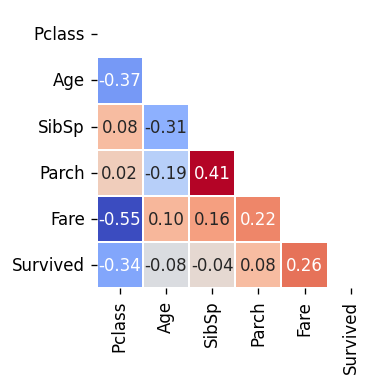

In [18]:
# 三角形の上部の配列のコピーを返す
mask = np.triu(correlation_matrix)

plt.figure(figsize=(3, 3), dpi=120)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, mask=mask, linewidths=1, cbar=False)
plt.show()

##### 1, 生存率はPclassと運賃運賃に対して直線的な関係がある。
##### 2, Pclassと運賃は負の相関関係がある。（１等席は運賃が高く、３等席は運賃が安いので）
##### 3, parchとSibSpは相関関係が高い。（つまり、両親や子供がいる人は、兄弟や配偶者と一緒にいる可能性が高いということ。）

## 性別　vs 生存

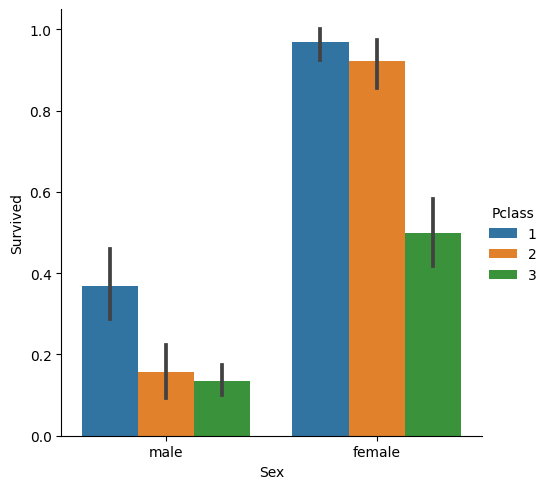

In [19]:
sns.catplot(data=Xy, x="Sex", y="Survived", hue="Pclass", kind="bar")

##### ・女性の乗客の生存率は男性の乗客のそれよりも高かった。
##### ・上位クラスの乗客の生存率は、下位クラスの乗客の生存率よりも高かった。

## 年齢 vs 生存

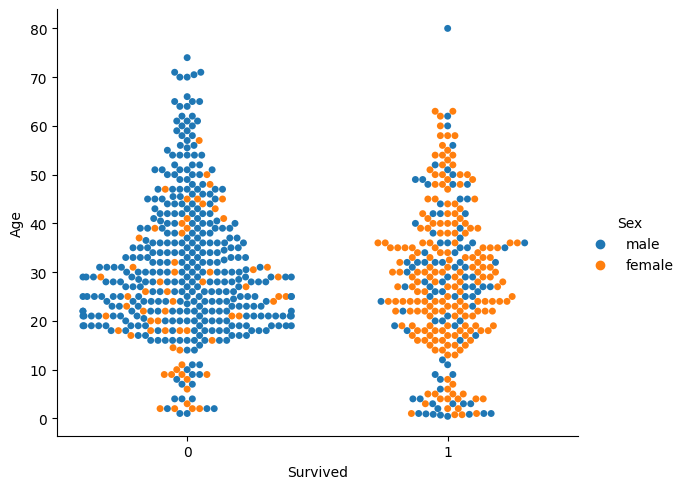

In [20]:
sns.catplot(data=Xy, y="Age", x="Survived", hue="Sex", kind="swarm", height=5, aspect=1.2);

##### ・50歳以上の男性乗客の生存率が低い
##### ・年齢が１０歳未満の乗客の方が生存率が高かった。

## 運賃 vs 生存

(0.0, 300.0)

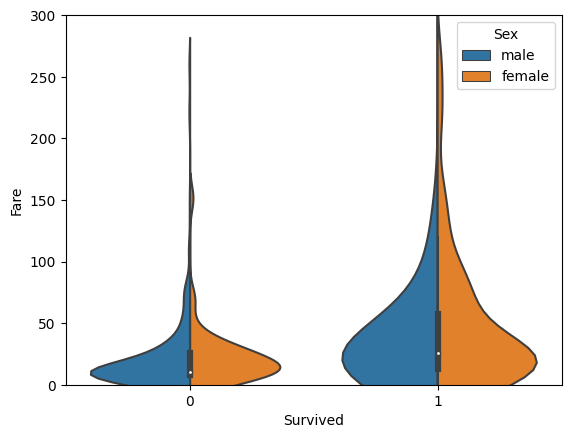

In [21]:
sns.violinplot(data=Xy, y="Fare", x="Survived", hue="Sex", split=True, height=10, aspect=1);
plt.ylim(0, 300)

#####　運賃が80以上の乗客は、生存率が高かった。

# 6)特徴量エンジニアリング

##　新規カテゴリー機能の作成

### 1, Name Prefix

In [22]:
X['Prefix'] = X['Name'].str.split(expand=True)[1]
X_test['Prefix'] = X_test['Name'].str.split(expand=True)[1]
# str.split():区切り文字で分割
# expand=True・・・DataFrame/MultiIndexの次元を拡張する。（expand=Trueを設定すると、出力がデータフレームになる。）
# [1]の部分は区切り文字の2つ目という意味を表している。[0]だったら一つ目を表していることになる。
# 複数の列に分割してpandas.DataFrameとして取得するには、引数expand=Trueを指定する。（デフォルトはexpand=False)

In [23]:
prefixes = X.Prefix.value_counts()
top_prefixes = prefixes[prefixes>len(X)/25].index
# len(X)/25X変数の数の25で割った数値を意味する。
top_prefixes

Index(['Mr.', 'Miss.', 'Mrs.', 'Master.'], dtype='object')

In [24]:
X.Prefix = X.Prefix.apply(lambda x : x if x in top_prefixes else 'other')
X_test.Prefix = X_test.Prefix.apply(lambda x : x if x in top_prefixes else 'other')
# 列prefixの要素が・・・xがtop_prefixesの中に入っていれば、xを返す。そうでなければotherを返す。
# applyはデフォルトでは各列に対して適用され、引数axis=1とすると各行に対して適用される。

In [25]:
# X[X['Prefix'] == 'other'].head(2)

In [26]:
df = pd.DataFrame(X['Prefix'].value_counts())
df['Prefix_test'] = X_test['Prefix'].value_counts().values
df

,Prefix,Prefix_test
Mr.,502,234
Miss.,179,77
Mrs.,121,70
other,49,19
Master.,40,18


## 年齢のインプット（グループ平均を使用）

In [27]:
# Ageが欠損しているカラムの真偽値をnull_index変数に格納する。
null_index = X.Age.isnull()
# Ageが欠損しているカラムの真偽値をnull_index_test変数に格納する。
null_index_test = X_test.Age.isnull()
print(null_index.sum(), null_index_test.sum())

177 86


In [28]:
avg_ages = X.groupby(['Prefix', 'Pclass']).Age.mean().round()
pd.DataFrame(avg_ages)

Age
Prefix  Pclass      
Master. 1        5.0
        2        2.0
        3        5.0
Miss.   1       30.0
        2       22.0
        3       16.0
Mr.     1       42.0
        2       33.0
        3       29.0
Mrs.    1       42.0
        2       34.0
        3       34.0
other   1       42.0
        2       38.0
        3       29.0

In [29]:
for (i, k) in avg_ages.index:
    # iとkは、avg_ageのindex
    value = avg_ages.loc[i, k]
    X.loc[(X.Prefix==i) & (X.Pclass==k) & (X.Age.isnull()), 'Age'] = value
    X_test.loc[(X_test.Prefix==i) & (X_test.Pclass==k) & (X_test.Age.isnull()), 'Age'] = value 
# 簡単に言うとAgeがNULLの行に、Prefix, Pclass毎の平均値を入れる作業を行なっている。
# valueにindexがi, kのageの値を格納
# Prefixがi, Pclassがk, Ageが欠損しているカラムにvalue(indexがi, kのageの値。つまり平均値を格納しておく。)
# X, X_testのどちらともで同様に行う。

In [30]:
# 年齢の欠損値の数
print(X['Age'].isnull().sum(), X_test['Age'].isnull().sum())

0 0


In [31]:
X[null_index].head()
# Ageがnullだった行に、Prefix, Pclass毎の平均年齢が入っているか確認。（無事入っていることが確認できる。）

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Prefix
PassengerId,,,,,,,,,,
6,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q,Mr.
18,2,"Williams, Mr. Charles Eugene",male,33.0,0,0,244373,13.0000,S,Mr.
20,3,"Masselmani, Mrs. Fatima",female,34.0,0,0,2649,7.2250,C,Mrs.
27,3,"Emir, Mr. Farred Chehab",male,29.0,0,0,2631,7.2250,C,Mr.
29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,16.0,0,0,330959,7.8792,Q,Miss.


In [32]:
# Sex(性別)カラムがあるので,Prefixカラムの情報は冗長になる。
# PreifxのMr,Miss,Mrs,Masterはknownと言う文字列に置き換えている。
X.Prefix = X.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')
X_test.Prefix = X_test.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')

In [33]:
# Nameカラムも不要なので消す。列を削除する場合は、axis=1を引数に入れる。
X = X.drop(['Name'], axis=1)
X_test = X_test.drop(['Name'], axis=1)

### 2,年齢カテゴリ

In [34]:
# cut()・・・ビニング処理（ビン分割）。連続値を任意の境界線で区切りカテゴリ分けして離散値に変換する。
# 年齢毎にカテゴリ分けをする。
def Age_categorie(df):
    df['Age_Cat'] = pd.cut(df.Age, bins = [0,10,40,60,100], labels = ['child','young','adult','senior'])

Age_categorie(X)
Age_categorie(X_test)
X['Age_Cat'].dtype

CategoricalDtype(categories=['child', 'young', 'adult', 'senior'], ordered=True)

In [35]:
df = pd.DataFrame(X['Age_Cat'].value_counts())
df['Age_Cat_test'] = X_test['Age_Cat'].value_counts().values
df

,Age_Cat,Age_Cat_test
young,644,307
adult,157,75
child,68,25
senior,22,11


### 3,運賃カテゴリ

In [36]:
# まず統計値を確認
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [37]:
# qcut()で分割（要素数が等しくなるようい分割。）
def Fare_categorie(df):
    df['Fare_Cat'] = pd.qcut(df.Fare, q=4, labels = ['low', 'medium', 'high', 'very_high'])
    
Fare_categorie(X)
Fare_categorie(X_test)
X['Fare_Cat'].dtype

CategoricalDtype(categories=['low', 'medium', 'high', 'very_high'], ordered=True)

In [38]:
df = pd.DataFrame(X['Fare_Cat'].value_counts())
df['Fare_Cat_test'] = X_test['Fare_Cat'].value_counts().values
df

,Fare_Cat,Fare_Cat_test
medium,224,114
low,223,105
high,222,102
very_high,222,96


### 4,家族構成

In [39]:
# データソースのSibSp（タイタニック号に載っている兄弟や配偶者）とparch(親と子供)のカラムを足して、Family（家族人数）カラムを作成し、不要となったSibSpとparchカラムを除去する。
X['Family'] = X['SibSp'] + X['Parch']
X_test['Family'] = X_test['SibSp'] + X_test['Parch']

X = X.drop(['SibSp', 'Parch'], axis=1)
X_test = X_test.drop(['SibSp', 'Parch'], axis=1)

In [40]:
X.Family.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [41]:
def Categorie_Family(df):
    df['Family_Size'] = pd.cut(df.Family, bins = [-1, 0, 2, 12], labels = ['alone', 'medium', 'large'])
    
Categorie_Family(X)
Categorie_Family(X_test)

In [42]:
df = pd.DataFrame(X['Family_Size'].value_counts())
df['Family_Size_test'] = X_test['Family_Size'].value_counts().values
df

,Family_Size,Family_Size_test
alone,537,253
medium,263,131
large,91,34


In [43]:
X.head()

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
1,3,male,22.0,A/5 21171,7.2500,S,known,young,low,1,medium
2,1,female,38.0,PC 17599,71.2833,C,known,young,very_high,1,medium
3,3,female,26.0,STON/O2. 3101282,7.9250,S,known,young,medium,0,alone
4,1,female,35.0,113803,53.1000,S,known,young,very_high,1,medium
5,3,male,35.0,373450,8.0500,S,known,young,medium,0,alone


In [44]:
X_test.head()

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
892,3,male,34.5,330911,7.8292,Q,known,young,low,0,alone
893,3,female,47.0,363272,7.0000,S,known,adult,low,1,medium
894,2,male,62.0,240276,9.6875,Q,known,senior,medium,0,alone
895,3,male,27.0,315154,8.6625,S,known,young,medium,0,alone
896,3,female,22.0,3101298,12.2875,S,known,young,medium,2,medium


## 作成したカテゴリのデータ可視化

In [45]:
# データ可視化のための、Xとyの連結
Xy = X.copy()
Xy['Survived'] = y.copy()

In [46]:
# 【matplotlib】rcParams・・・matplotlibのデフォルト設定が格納されている。設定値を返すことで、プログラム全体のグラフに対して設定を変更することができる。
plt.rcParams.update(plt.rcParamsDefault)

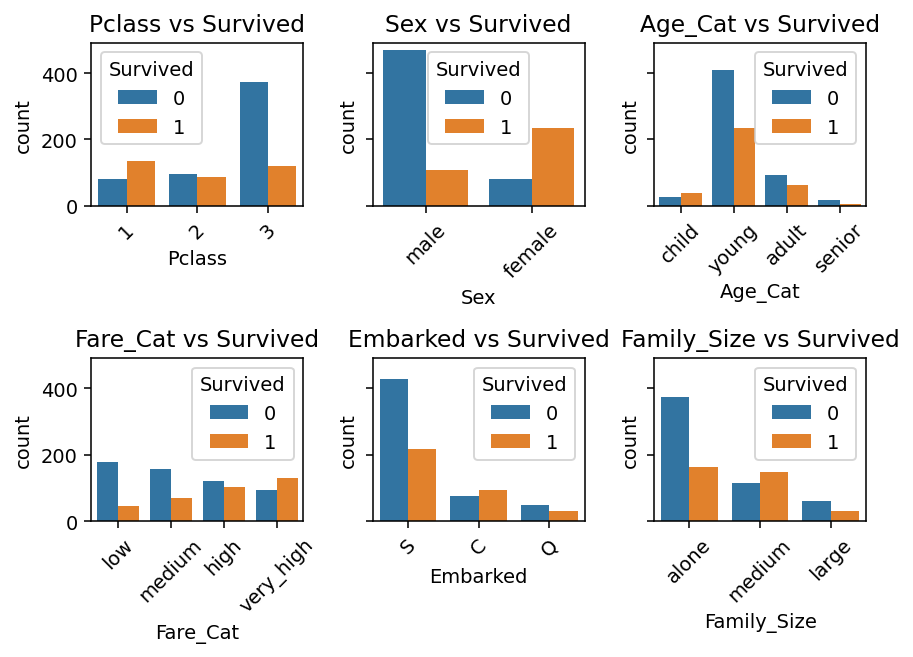

In [47]:
l=['Pclass', 'Sex', 'Age_Cat', 'Fare_Cat', 'Embarked', 'Family_Size']
figure, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=False, dpi=140)
index = 0
axes = axes.flatten()
for axis in axes:
    sns.countplot(x = l[index], hue = "Survived", data = Xy, ax=axis)
    axis.set_title(l[index]+' vs Survived')
    index = index+1
    plt.tight_layout()
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)
plt.show()

### Survived＝１がSurvived＝０よりも大きい場合は
#### ・Pclass＝１
#### ・Sex＝female
#### ・Age_Cat＝child
#### ・Fare_Cat＝very_high
#### ・Embarked＝C
#### ・Family_Size＝medium

# 7)特徴量の選択

In [48]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'Ticket', 'Fare', 'Embarked', 'Prefix',
       'Age_Cat', 'Fare_Cat', 'Family', 'Family_Size'],
      dtype='object')

In [49]:
# 分類モデルのためのカラムを選択する。
X = X[['Age', 'Pclass', 'Sex', 'Family_Size']]
X_test = X_test[['Age', 'Pclass', 'Sex', 'Family_Size']]

In [50]:
# 数値カラムを選択する。
numerical_cols = [cname for cname in X.columns
                  if X[cname].dtype in ['int64', 'float64']]

In [51]:
# カーディナリティが低いカラムを選択する。
categorical_cols = [cname for cname in X.columns
                    if X[cname].nunique() < 10 and
                    X[cname].dtype in ["object", "category"]]

In [52]:
my_cols = numerical_cols + categorical_cols
X = X[my_cols]
X_test = X_test[my_cols]

In [53]:
print(my_cols)

['Age', 'Pclass', 'Sex', 'Family_Size']


## 回帰モデルを学習させる最終的なXとX_test

In [54]:
print(len(categorical_cols), len(numerical_cols))

2 2


In [55]:
X_test.head()

,Age,Pclass,Sex,Family_Size
PassengerId,,,,
892,34.5,3,male,alone
893,47.0,3,female,medium
894,62.0,2,male,alone
895,27.0,3,male,alone
896,22.0,3,female,medium


In [56]:
show_info(X, X_test)
# show_info()・・・

Number of Columns with different Data Types:

          X  X_test
float64   1       1
int64     1       1
object    1       1
category  1       1 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Age,float64,88,79,0,0
Pclass,int64,3,3,0,0
Sex,object,2,2,0,0
Family_Size,category,3,3,0,0


# 8)モデル構築

## 前処理パイプライン

In [57]:
# 数値データの前処理
numerical_transformer = SimpleImputer(strategy='median')
# 【scikit-learn】SimpleImputer・・・デフォルト値は、欠損値に各属性の平均値を置き換える設定となっている。
# └strategy・・・統計値の種類。(median=中央値）

In [58]:
# カテゴリデータの前処理
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# One Hot Encoding・・・カテゴリ変数に対する最も代表的なハンドリング方法。カテゴリ変数の各水準に対して、その水準化どうかを表す0,1の2値変数をそれぞれ作成する。
# hundle_unknown='ignore'・・・未知のクラスの場合はその特徴量のクラスベクトルが全て0になる。デフォルトは'error'で、未知のクラスに遭遇するとエラーを返す。

In [59]:
# 数値データおよびカテゴリデータのバンドル前処理
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# ColumnTransfomer・・・カラム毎に異なるtransfomersを適用する。

## Model Pipeline

In [60]:
xgb = XGBClassifier()

classifier = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', xgb)
                             ])

# pipelineモジュール・・・transformerとestimatorを組み合わせて、機械学習パイプラインを構築するためのAPI
# └いくつかの前処理を実行しているような場合にも、fitやpredictをパイプラインに対して一度だけ呼べばよく、便利になる。
# └パイプラインに対して、grid searchする際、パラメータを一度に指定でき、利便性が高い。
# └transformerとestimatorに同じデータが使われるため、Cross Vaidationの際にデータがリークする不具合を防げる。

## Visualize Pipeline

In [61]:
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Family_Size'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsampl...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

# 9)トレーニングモデルとテストモデル

###　グリッドリサーチ & クロスバリデーション

In [62]:
param_grid = [
    {
        "model__reg_lambda": [50],
        "model__subsample": [0.7,1],
        "model__learning_rate": [0.4],
        "model__n_estimators": [5, 10, 20],
        "model__max_depth": [3, 4, 5]
    }
]
grid_search = GridSearchCV(classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X, y);

# グリッドサーチ・・・探索対象のパラメータ候補を列挙し、そのすべての組み合わせから照らし合わせ、最適な組み合わせを見つけ出す手法。
# GridSearchCVのパラメータ。
# 第一引数（今回はclassifier)は使用したいアルゴリズムのインスタンスをおく。
# └param_grid:パラメタ候補値を「パラメタ名、候補リスト」の辞書で与える。
# └cv:Cross Validationの分散数（デフォルト値は３）
# └verbose:ログ出力レベル

# fit()で学習、predict()で予測。（scikit-learn)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [63]:
print("Best params:", grid_search.best_params_, sep='/t', end='\n\n')
print("Best score in grind search:", round(grid_search.best_score_, 3), sep='\t')
print("Score on whole trained data:",round(grid_search.score(X, y),3),sep='\t')

Best params:/t{'model__learning_rate': 0.4, 'model__max_depth': 3, 'model__n_estimators': 10, 'model__reg_lambda': 50, 'model__subsample': 1}

Best score in grind search:	0.82
Score on whole trained data:	0.826


In [64]:
# パラメータコンビネーションTop５
df = pd.DataFrame(grid_search.cv_results_)
display(df.sort_values('rank_test_score')[:5])
# cv_results_属性・・・各パラメータ毎の学習結果を確認することができる。
# sort_values()・・・要素の値に応じてソートする。
# displayがDataFrame形式のレイアウトを保持してくれる。DataFrame特有のレイアウトで表示したい時は、printではなくdisplayを使うと良い。

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__reg_lambda,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.025794,0.000253,0.011845,0.000022,0.4,3,10,50,1,"{'model__learning_rate': 0.4, 'model__max_dept...",0.811448,0.835017,0.814815,0.820426,0.010408,1
4,0.030690,0.001265,0.011873,0.000135,0.4,3,20,50,0.7,"{'model__learning_rate': 0.4, 'model__max_dept...",0.801347,0.831650,0.814815,0.815937,0.012397,2
11,0.032019,0.002065,0.012085,0.000227,0.4,4,20,50,1,"{'model__learning_rate': 0.4, 'model__max_dept...",0.787879,0.831650,0.821549,0.813692,0.018713,3
1,0.027265,0.001943,0.013168,0.001228,0.4,3,5,50,1,"{'model__learning_rate': 0.4, 'model__max_dept...",0.811448,0.811448,0.814815,0.812570,0.001587,4
7,0.023668,0.000132,0.012614,0.000646,0.4,4,5,50,1,"{'model__learning_rate': 0.4, 'model__max_dept...",0.808081,0.818182,0.811448,0.812570,0.004199,4


## 特徴量の重要度

In [65]:
Feature_Imp = grid_search.best_estimator_.named_steps["model"].feature_importances_
Feature_Imp

array([0.07271594, 0.08572008, 0.776088  , 0.        , 0.01490091,
       0.02322893, 0.02734616], dtype=float32)

In [66]:
# 学習済データに対するyの予測
y_pred = grid_search.predict(X)

# y_predを配列からDataFrameに変換し、適切なインデックスとカラム名を付与する。
y_pred = pd.DataFrame(y_pred, index=X.index, columns=['Survived_Predicted'])

In [67]:
Xyy = pd.concat([X, y, y_pred], axis=1)
Xyy.head(2)
# concat・・・DataFrameやSiriesを連結する。axis=0は縦方向に連結され、axis=1は横方向に連結される。

,Age,Pclass,Sex,Family_Size,Survived,Survived_Predicted
PassengerId,,,,,,
1,22.0,3,male,medium,0,0
2,38.0,1,female,medium,1,1


In [68]:
# パイプラインを用いた前処理（ImputedとOneHotCoded)されたトレーニングデータとテストデータ
column_values = ['Age','Pclass','Sex_female','Sex_male','Family_alone','Family_large','Family_medium']
X_processed = pd.DataFrame(grid_search.best_estimator_.named_steps["preprocessor"].transform(X), columns=column_values)
X_processed.head(2)

,Age,Pclass,Sex_female,Sex_male,Family_alone,Family_large,Family_medium
0,22.0,3.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,1.0,0.0,0.0,0.0,1.0


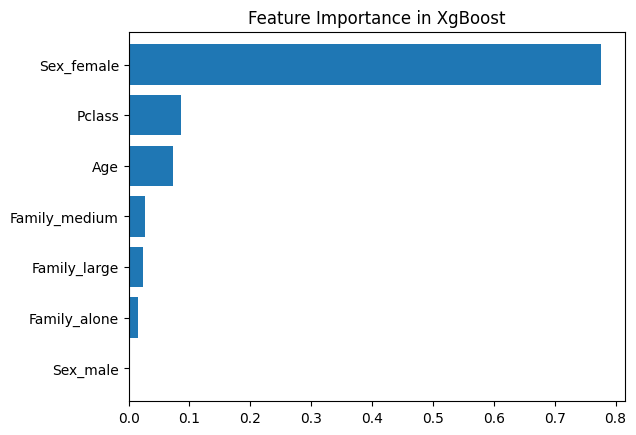

In [69]:
ax = pd.Series(Feature_Imp, X_processed.columns).sort_values(ascending=True).plot.barh(width=0.8)
ax.set_title('Feature Importance in XgBoost')
plt.show()

#### Sex_maleが、学習済XGBoostモデルにおいて重要性がゼロであることが分かる。(同じ情報がSex_femaleで伝達されるため。）

## コンフュージョンマトリックス（学習データ用）。

In [70]:
# Credit: 'https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea'
cm = confusion_matrix(y, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'])
ax.set(ylabel="Actual y", xlabel="Predicted y");

# 分類レポート（学習データ用）

In [71]:
print(classification_report(y, y_pred))
# classification_report・・・正解ラベル列と予測ラベル列を入力すると、precision, recall, F1score, accuracy, マクロ平均, マイクロ平均を算出してくれる。

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       549
           1       0.81      0.71      0.76       342

    accuracy                           0.83       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.83      0.83      0.82       891



In [72]:
# モデル評価指標
print('Accuracy Score : ' + str(accuracy_score(y,y_pred).round(3)))
print('Precision Score : ' + str(precision_score(y,y_pred).round(3)))
print('Recall Score : ' + str(recall_score(y,y_pred).round(3)))
print('F1 Score : ' + str(f1_score(y,y_pred).round(3)))

Accuracy Score : 0.826
Precision Score : 0.813
Recall Score : 0.711
F1 Score : 0.758


# 10)yを予測する

In [76]:
# テストの予測値を生成
y_test_pred = grid_search.predict(X_test)

# y_predを配列からDataFrameに変換し、適切なインデックスとカラム名を付与する。
y_test_pred = pd.DataFrame(y_test_pred, index=X_test.index, columns=['Survived_Predicted'])

In [77]:
#　特徴量と予測対象でテストデータを確認
Xy_test = pd.concat([X_test,y_test_pred],axis=1)
Xy_test.head(2)

,Age,Pclass,Sex,Family_Size,Survived_Predicted
PassengerId,,,,,
892,34.5,3,male,alone,0
893,47.0,3,female,medium,1


In [78]:
# Save output to CSV file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': y_test_pred.Survived_Predicted})
output.to_csv('submission.csv', index=False)

In [79]:
# Submit results
submission_data = pd.read_csv("submission.csv")
submission_data.head(2)

,PassengerId,Survived
0,892,0
1,893,1
